<a href="https://colab.research.google.com/github/AdrianaCott14/CS_472/blob/main/lab_2_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation Lab





In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import pdb
from math import e
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import random

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e., do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [ ]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None, deterministic=None, initial_weight=0.0):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.input_to_hidden = None
        self.hidden_to_output = None
        self.deterministic = deterministic 
        if initial_weight == None:
          self.initial_weight = random.uniform(0, 1)
        else:
          self.initial_weight = initial_weight

        self.train_accuracy = []
        self.valid_accuracy = []
        self.train_mse = []
        self.valid_mse = []


    def fit(self, X, y, initial_weights=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        # set initial weights
        self.initialize_weights(len(X[0]) + 1, len(y[0]), self.initial_weight)     

        # check if a deterministic has been specified
        if self.deterministic == None:

          bContinue = True
          self.epoch = 0

          accuracy_counter = 0
          best_accuracy = 0.0

          while bContinue == True:
            # shuffle data
            X, y = self._shuffle_data(X, y)
            validation_x, train_x, validation_y, train_y = self.split_data(X, y, .85)

            self.train_accuracy.append(self.score(train_x, train_y))
            self.valid_accuracy.append(self.score(validation_x, validation_y))
            
            self.train_mse.append(np.square(np.subtract(train_y, self.predict(train_x))).sum()/len(train_y))   
            self.valid_mse.append(np.square(np.subtract(validation_y, self.predict(validation_x))).sum()/len(validation_y)) 

            # add the bias at the end of each pattern
            patterns = np.append(train_x, np.ones((train_x.shape[0], 1)), axis=1)            

            # loop through all inputs (X)
            for row in range(len(patterns)):
              currRow = patterns[row]
              hidden_zs = []
              output_zs = []
              output_deltas = []
              hidden_deltas = []

              # input to hidden
              hidden_nets = currRow @ self.input_to_hidden
              for i in range(len(hidden_nets)):
                z = 1/(1 + e**-(hidden_nets[i]))
                hidden_zs.append(z) 
              hidden_zs.append(1)
              hidden_zs = np.array(hidden_zs)

              # hidden to output
              output_nets = hidden_zs @ self.hidden_to_output
              for i in range(len(output_nets)):
                z = 1/(1 + e**-(output_nets[i]))
                output_zs.append(z)
              output_zs = np.array(output_zs)

               # delta
              for i in range(len(output_zs)):
                output_deltas.append(((y[row][i] - output_zs[i])*(output_zs[i])*(1 - output_zs[i])))
              output_deltas = np.array(output_deltas)
              
              # output to hidden
              hidden_deltas = []
              for j in range(len(self.hidden_to_output) - 1):
                w_js = self.hidden_to_output[j]
                sum = 0
                for k in range(len(output_deltas)):
                  sum += w_js[k] * output_deltas[k]
                hidden_deltas.append(sum * ((hidden_zs[j]) * (1 - hidden_zs[j])))
              
              # output to hidden
              for row_ in range(len(self.hidden_to_output)):
                for col in range(len(self.hidden_to_output[row_])):
                  self.hidden_to_output[row_][col] += self.lr * hidden_zs[row_] * output_deltas[col] + self.hidden_to_output_changes[row_][col] * self.momentum
                  self.hidden_to_output_changes[row_][col] = self.lr * hidden_zs[row_] * output_deltas[col] + self.hidden_to_output_changes[row_][col] * self.momentum
              
              # input to hidden
              for row_ in range(len(self.input_to_hidden)):
                for col in range(len(self.input_to_hidden[row_])):
                  self.input_to_hidden[row_][col] += self.lr * patterns[row][row_] * hidden_deltas[col] + self.input_to_hidden_changes[row_][col] * self.momentum
                  self.input_to_hidden_changes[row_][col] = self.lr * patterns[row][row_] * hidden_deltas[col] + self.input_to_hidden_changes[row_][col] * self.momentum
            

            # calc accuracy for validation set
            curr_accuracy = self.score(validation_x, validation_y)

            if best_accuracy < curr_accuracy:
              best_accuracy = curr_accuracy
              accuracy_counter = 0
            else:
              accuracy_counter += 1

            #if counter is high enough, break
            if accuracy_counter == 25:
              bContinue = False
            if bContinue == True:
              self.epoch += 1        

        else: 
          # add the bias at the end of each pattern
          patterns = np.append(X, np.ones((X.shape[0], 1)), axis=1)

          for epoch in range(self.deterministic):
            # loop through all inputs (X)
            for row in range(len(patterns)):
              currRow = patterns[row]
              hidden_zs = []
              output_zs = []
              output_deltas = []
              hidden_deltas = []

              # input to hidden
              hidden_nets = currRow @ self.input_to_hidden
              for i in range(len(hidden_nets)):
                z = 1/(1 + e**-(hidden_nets[i]))
                hidden_zs.append(z) 
              hidden_zs.append(1)
              hidden_zs = np.array(hidden_zs)

              # hidden to output
              output_nets = hidden_zs @ self.hidden_to_output
              for i in range(len(output_nets)):
                z = 1/(1 + e**-(output_nets[i]))
                output_zs.append(z)
              output_zs = np.array(output_zs)
                    
              # delta
              for i in range(len(output_zs)):
                output_deltas.append(((y[row][i] - output_zs[i])*(output_zs[i])*(1 - output_zs[i])))
              output_deltas = np.array(output_deltas)
              
              # output to hidden
              hidden_deltas = []
              for j in range(len(self.hidden_to_output) - 1):
                w_js = self.hidden_to_output[j]
                sum = 0
                for k in range(len(output_deltas)):
                  sum += w_js[k] * output_deltas[k]
                hidden_deltas.append(sum * ((hidden_zs[j]) * (1 - hidden_zs[j])))
              
              # output to hidden
              for row_ in range(len(self.hidden_to_output)):
                for col in range(len(self.hidden_to_output[row_])):
                  self.hidden_to_output[row_][col] += self.lr * hidden_zs[row_] * output_deltas[col] + self.hidden_to_output_changes[row_][col] * self.momentum
                  self.hidden_to_output_changes[row_][col] = self.lr * hidden_zs[row_] * output_deltas[col] + self.hidden_to_output_changes[row_][col] * self.momentum
              
              # input to hidden
              for row_ in range(len(self.input_to_hidden)):
                for col in range(len(self.input_to_hidden[row_])):
                  self.input_to_hidden[row_][col] += self.lr * patterns[row][row_] * hidden_deltas[col] + self.input_to_hidden_changes[row_][col] * self.momentum
                  self.input_to_hidden_changes[row_][col] = self.lr * patterns[row][row_] * hidden_deltas[col] + self.input_to_hidden_changes[row_][col] * self.momentum
                  
        # print(hidden_nets, "hidden nets")
        # print(hidden_zs, "hidden zs")
        # print(output_nets, "output nets")
        # print(output_zs,"output zs")
        # print(output_deltas,"output delta")
        # print(hidden_deltas, "hidden deltas")
        # print(self.hidden_to_output, "hidden weights")
        # print(self.input_to_hidden, "input weights")
        # print(self.predictions, "predictions")

        return self


    def predict(self, X):
      predictions = []
      patterns = np.append(X, np.ones((X.shape[0], 1)), axis=1)
      for row in range(len(patterns)): # for every row being passed into the model
        currRow = patterns[row]
        hidden_zs = []
        output_zs = []
        output_deltas = []
        hidden_deltas = []

        # input to hidden
        hidden_nets = currRow @ self.input_to_hidden
        for i in range(len(hidden_nets)):
          z = 1/(1 + e**-(hidden_nets[i]))
          hidden_zs.append(z) 
        hidden_zs.append(1)
        hidden_zs = np.array(hidden_zs)


        # hidden to output
        output_nets = hidden_zs @ self.hidden_to_output
        for i in range(len(output_nets)):
          z = 1/(1 + e**-(output_nets[i]))
          output_zs.append(z)
        output_zs = np.array(output_zs)
        
        # predictions for binary classification
        if len(output_zs) == 1:
          pred = 1 if output_zs[0] > 0.5 else 0

          # save prediction to a list of predictions for each row in X
          predictions.append([pred])
        
        # predictions for mult outputs
        else:
          max_z = max(output_zs)
          max_z_index = np.where(output_zs == max_z)
          pred = [0 for i in range(len(output_zs))]
          pred[max_z_index[0][0]] = 1
          predictions.append(pred)

      return np.array(predictions)


    def score(self, X, y):
      return (self.predict(X) == y).mean()
      

    def initialize_weights(self, input_height, output_height, initial_weight):
        """ 
            Initialize weights
        """
        self.input_to_hidden = np.full((input_height, self.hidden_layer_widths[0]), initial_weight)
        self.hidden_to_output = np.full((self.hidden_layer_widths[0] + 1, output_height), initial_weight)

        self.input_to_hidden_changes = np.full((input_height, self.hidden_layer_widths[0]), initial_weight)
        self.hidden_to_output_changes = np.full((self.hidden_layer_widths[0] + 1, output_height), initial_weight)

        return 

    def split_data(self, X, y, split_perct):
        len_y = len(y[0])
        len_x = len(X[0])
      
        # check classification
        if len_y > 1:
          splitPoint = round(split_perct * len(X))

          X_train = X[:splitPoint]
          X_test = X[-(len(X) - splitPoint):]
          y_train = y[:splitPoint]
          y_test = y[-(len(X) - splitPoint):]
        
        else:
          splitPoint = round(split_perct * len(X))

          X_train = X[:splitPoint]
          X_test = X[-(len(X) - splitPoint):]
          y_train = y[:splitPoint]
          y_test = y[-(len(X) - splitPoint):]

        # print(X_train, "x train")
        # print(X_test, "x test")
        # print(y_train, "y train")
        # print(y_test,"y test")
        
        return X_test, X_train, y_test, y_train

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
              shuffling X and y exactly the same way, independently.
        """
        shuffleNP = np.append(X, y, axis=1)
        np.random.shuffle(shuffleNP)
        X = shuffleNP[:, :len(X[0])] # X
        y = shuffleNP[:, len(X[0]):] # y

        return X, y

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        print("Layer 1: ", self.input_to_hidden)
        print("Layer 2: ", self.hidden_to_output)
        return


## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://byu.instructure.com/courses/14142/files?preview=4421290)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://byu.instructure.com/courses/14142/files?preview=4537323) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://byu.instructure.com/courses/14142/files?preview=4537340) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [ ]:
# Load debug data
data = arff.loadarff('/content/linsep2nonorigin.arff')
df = pd.DataFrame(data[0])
debugDataNP = np.array(df)

debugInputs = debugDataNP[:, :-1].astype(float) # X
# Binary classification
debugTargets = debugDataNP[:, -1:].astype(int) # y
# print(debugTargets)

# One Hot classification
debugTargetsOneHot = []
for i in range(len(debugTargets)):
  if debugTargets[i] == 0 :
    debugTargetsOneHot.append([1, 0])
  else:
    debugTargetsOneHot.append([0, 1])
# print(debugTargetsOneHot)

# Train on debug data
model = MLP(momentum=.5, hidden_layer_widths=[4], deterministic=10)
model.fit(debugInputs, debugTargetsOneHot)

# Print weights
model.get_weights()

Layer 1:  [[-0.00018149 -0.00018149 -0.00018149 -0.00018149]
 [ 0.00157468  0.00157468  0.00157468  0.00157468]
 [-0.00788218 -0.00788218 -0.00788218 -0.00788218]]
Layer 2:  [[ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.02148778 -0.02148778]]


### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://byu.instructure.com/courses/14142/files?preview=4421294)

In [ ]:
# Load Eval data
data = arff.loadarff('/content/data_banknote_authentication.arff')
df = pd.DataFrame(data[0])
evalDataNp = np.array(df)

evalInputs = evalDataNp[:, :-1].astype(float) # X
# Binary classification
evalTargets = evalDataNp[:, -1:].astype(int) # y

# One hot classification
evalTargetsOneHot = []
for i in range(len(evalTargets)):
  if evalTargets[i] == 0 :
    evalTargetsOneHot.append([1, 0])
  else:
    evalTargetsOneHot.append([0, 1])


# Train on debug data
model = MLP(momentum=.5, hidden_layer_widths=[4], deterministic=10)
model.fit(evalInputs, evalTargets)

# Print weights
model.get_weights()

Layer 1:  [[ 1.30932366  1.30932366  1.30932366  1.30932366]
 [ 0.80601033  0.80601033  0.80601033  0.80601033]
 [ 0.92744187  0.92744187  0.92744187  0.92744187]
 [ 0.22165294  0.22165294  0.22165294  0.22165294]
 [-1.45313731 -1.45313731 -1.45313731 -1.45313731]]
Layer 2:  [[-1.88512443]
 [-1.88512443]
 [-1.88512443]
 [-1.88512443]
 [ 4.57969955]]


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

Test Accuracy:  0.9777777777777777


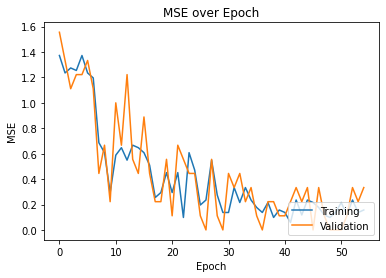

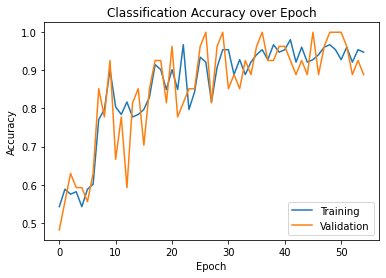

In [ ]:
# Iris Classification
# Load Iris data
data = arff.loadarff('/content/iris.arff')
df = pd.DataFrame(data[0])

IrisDataNP = np.array(df)

irisInputs = IrisDataNP[:, :4].astype(float) # X
# Binary classification
irisTargets = IrisDataNP[:, 4:] # y
# print(irisTargets)

# Encod the targets
irisTargetEncoded = []
for i in range(len(irisTargets)):
  if irisTargets[i] == b'Iris-setosa' :
    irisTargetEncoded.append([1, 0, 0])
  elif irisTargets[i] == b'Iris-versicolor':
    irisTargetEncoded.append([0, 1, 0])
  else:
    irisTargetEncoded.append([0, 0, 1])
# print(irisTargetEncoded)

# build model
num_hidden_nodes = 2 * (len(irisInputs[0])) # twice the hidden nodes as inputs
model = MLP(hidden_layer_widths=[num_hidden_nodes], momentum=.5)

x_shuffled, y_shuffled = model._shuffle_data(irisInputs, irisTargetEncoded)
x_test, x_train, y_test, y_train = model.split_data(x_shuffled, y_shuffled, .8)

model.fit(x_train, y_train)

print("Test Accuracy: ", model.score(x_test, y_test))

# graph MSE (y) over epochs (x) training + validation
y_training = model.train_mse
y_valid = model.valid_mse

plt.plot(y_training)
plt.plot(y_valid)

plt.title("MSE over Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(["Training", "Validation"], loc ="lower right")

plt.show()

# graph accuracy (y) over epochs (x) 
y_acc_train = model.train_accuracy
y_acc_valid = model.valid_accuracy

plt.title("Classification Accuracy over Epoch")
plt.plot(y_acc_train)
plt.plot(y_acc_valid)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"], loc ="lower right")

plt.show()

## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://byu.instructure.com/courses/14142/files?preview=4537354)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

0.01 lr
Test Accuracy:  0.8255280073461891
0.204 lr
Test Accuracy:  0.8310376492194674
0.168 lr
Test Accuracy:  0.8319559228650137
0.544 lr
Test Accuracy:  0.8347107438016529
0.852 lr
Test Accuracy:  0.8356290174471993
1.61 lr
Test Accuracy:  0.8310376492194674


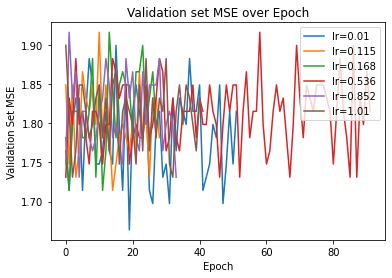

In [ ]:
# Vowel Classification
# Load Iris data
data = arff.loadarff('/content/vowel.arff')
df = pd.DataFrame(data[0])

vowelDataNP = np.array(df)

# Binary classification
vowelInputs = vowelDataNP[:, 2:-1] # X
vowelTargets = vowelDataNP[:, -1:] # y
# print(irisTargets)

# Male -- 0
# Female -- 1
for i in range(len(vowelInputs)):
  if vowelInputs[i][0] == b'Male':
    vowelInputs[i] = 0
  else:
    vowelInputs[i] = 1

# hid, hId, hEd, hAd, hYd, had, hOd, hod, hUd, hud, hed
vowelTargetEncoded = []
for i in range(len(vowelTargets)):
  if vowelTargets[i] == b'hid' :
    vowelTargetEncoded.append([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  elif vowelTargets[i] == b'hId' :
    vowelTargetEncoded.append([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  elif vowelTargets[i] == b'hEd' :
    vowelTargetEncoded.append([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
  elif vowelTargets[i] == b'hAd' :
    vowelTargetEncoded.append([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
  elif vowelTargets[i] == b'hYd' :
    vowelTargetEncoded.append([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
  elif vowelTargets[i] == b'had' :
    vowelTargetEncoded.append([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
  elif vowelTargets[i] == b'hOd' :
    vowelTargetEncoded.append([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
  elif vowelTargets[i] == b'hod' :
    vowelTargetEncoded.append([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
  elif vowelTargets[i] == b'hUd' :
    vowelTargetEncoded.append([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
  elif vowelTargets[i] == b'hud' :
    vowelTargetEncoded.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
  else:
    vowelTargetEncoded.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
# print(irisTargetEncoded)

num_hidden_nodes = 2 * (len(vowelInputs[0])) # twice the hidden nodes as inputs

# list of test learning rates 
test_lr = [0.01, 0.204, 0.168, 0.544, 0.852, 1.61]
# test_lr = [0.01, 0.115]

for lr in range(len(test_lr)):
  print(test_lr[lr], "lr")
  model = MLP(hidden_layer_widths=[num_hidden_nodes], lr=test_lr[lr], momentum=.5)

  x_shuffled, y_shuffled = model._shuffle_data(vowelInputs, vowelTargetEncoded)
  x_test, x_train, y_test, y_train = model.split_data(x_shuffled, y_shuffled, .8)
  
  model.fit(x_train, y_train)

  y = model.valid_mse
  plt.plot(y)
  print("Test Accuracy: ", model.score(x_test, y_test))
  
  

plt.title("Validation set MSE over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Set MSE")
plt.legend(["lr=0.01", "lr=0.115", "lr=0.168", "lr=0.536", "lr=0.852", "lr=1.01"], loc ="upper right")
# plt.ylim([.14, .2])

plt.show()

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



After trying out a couple different learning rates, it's hard to tell which had the biggest impact. One thing that is deifinitely clear is the amount of epochs it took for each model to run. Each learning rate returned pretty similar accuracies but some of them took a lot longer to do so. I think I will chose lr=0.852 for my next couple models as it finished with a pretty low MSE and didn't take very long to run. 

I think the vowel data set might be more difficult than Iris because there are quite a bit more output nodes. Iris only had 3 possible output nodes, whereas vowel has about 11. There is also more categorical data in the vowel set. I decided to ignore the train/test and speaker, and coded gender from 'male' and 'female' to a 0 or 1. I figured that train/test and speaker wouldn't have that big of an effect on the model overall, but because gender was easy transform into nominal data, it was easy to keep. 



## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

Test Accuracy:  0.8347107438016529
Num Hidden Nodes: 1
Current Best Accuracy: 0
Test Accuracy:  0.837465564738292
Num Hidden Nodes: 2
Current Best Accuracy: 0.8347107438016529
Test Accuracy:  0.830119375573921
Num Hidden Nodes: 4
Current Best Accuracy: 0.837465564738292
Test Accuracy:  0.8310376492194674
Num Hidden Nodes: 8
Current Best Accuracy: 0.837465564738292
Test Accuracy:  0.8328741965105602
Num Hidden Nodes: 16
Current Best Accuracy: 0.837465564738292


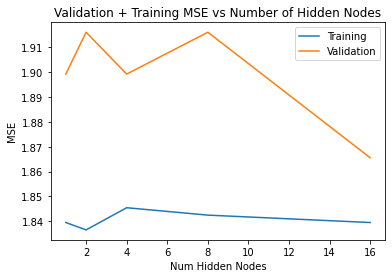

In [ ]:
# while loop for each test
bContinue = True
num_hidden_nodes = 1
best_accuracy = 0
best_val_mse = []
best_train_mse = []
num_nodes = []
accuracy_counter = 0

while bContinue == True:
  # shuffle and split data
  model = MLP(hidden_layer_widths=[num_hidden_nodes], momentum=.5, lr=0.852) # add best lr from above

  x_shuffled, y_shuffled = model._shuffle_data(vowelInputs, vowelTargetEncoded)
  x_test, x_train, y_test, y_train = model.split_data(x_shuffled, y_shuffled, .8)

  # run the model
  model.fit(x_train, y_train)
  curr_accuracy = model.score(x_test, y_test)
  best_val_mse.append(max(model.valid_mse))
  best_train_mse.append(max(model.train_mse))

  print("Test Accuracy: ", model.score(x_test, y_test))
  print("Num Hidden Nodes:", num_hidden_nodes)
  print("Current Best Accuracy:", best_accuracy)

  # check model test accuracy improvement
  if best_accuracy < curr_accuracy:
    best_accuracy = curr_accuracy
    accuracy_counter = 0
  else:
    accuracy_counter += 1
  
  # track number of hidden nodes
  num_nodes.append(num_hidden_nodes)

  #if counter is high enough, break
  if accuracy_counter == 3:
    bContinue = False
  if bContinue == True:
    num_hidden_nodes = num_hidden_nodes * 2 # double amount of hidden nodes
  
  
# graph MSE (y) over epochs (x) training + validation
plt.plot(num_nodes, best_train_mse)
plt.plot(num_nodes, best_val_mse)

plt.title("Validation + Training MSE vs Number of Hidden Nodes")
plt.xlabel("Num Hidden Nodes")
plt.ylabel("MSE")
plt.legend(["Training", "Validation"], loc ="upper right")

plt.show()

Similar to the tests I ran on learning rate, I noticed that there wasn't a huge difference in accuracy when running the model with different numbers of hidden nodes. After having just 2 hidden nodes, I was able to get my best accuracy for the model and so will be using that for the next set of tests. The biggest difference I noticed was that having more hidden nodes meant the model took longer to run, which is what I expected going into this test. 



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

Test Accuracy:  0.8292011019283747
Momentum: 0.01
Test Accuracy:  0.830119375573921
Momentum: 0.08
Test Accuracy:  0.8310376492194674
Momentum: 0.25
Test Accuracy:  0.8310376492194674
Momentum: 0.5
Test Accuracy:  0.8356290174471993
Momentum: 0.96


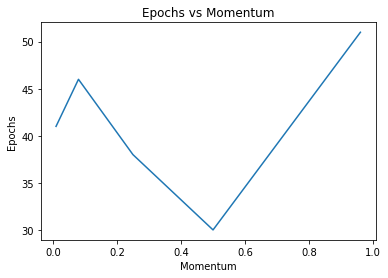

In [ ]:
# while loop for each test
bContinue = True
num_hidden_nodes = 2
test_momentum = [.01, .08, .25, .5, .96]
epochs = []

for m in range(len(test_momentum)):
  # shuffle and split data
  model = MLP(hidden_layer_widths=[num_hidden_nodes], momentum=test_momentum[m]) # add best lr from above

  x_shuffled, y_shuffled = model._shuffle_data(vowelInputs, vowelTargetEncoded)
  x_test, x_train, y_test, y_train = model.split_data(x_shuffled, y_shuffled, .8)

  # run the model
  model.fit(x_train, y_train)
  curr_accuracy = model.score(x_test, y_test)
  epochs.append(model.epoch)

  print("Test Accuracy: ", model.score(x_test, y_test))
  print("Momentum:", test_momentum[m])

plt.plot(test_momentum, epochs)

plt.title("Epochs vs Momentum")
plt.xlabel("Momentum")
plt.ylabel("Epochs")

plt.show()

While the accuracy didn't change that drastically for each momentum, I can see that the number of epochs that the model ran was at it's lowest around momentum of about .5. I think that if the momentum is either too high or too low, it's difficult for the algorithm to learn efficiently.



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [ ]:
# Iris data set
X_train, X_test, y_train, y_test = train_test_split(irisInputs, irisTargetEncoded, test_size=0.33, random_state=42)
clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=(28), 
                    activation='relu', learning_rate='adaptive', learning_rate_init=.01, 
                    alpha=.0001, momentum=.5, nesterovs_momentum=True, early_stopping=False).fit(X_train, y_train)

print("Iris data set: ", clf.score(X_test, y_test))

# Vowel data set
X_train, X_test, y_train, y_test = train_test_split(vowelInputs, vowelTargetEncoded, test_size=0.33, random_state=24)
clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=(50), 
                    activation='tanh', learning_rate='constant', learning_rate_init=.01, 
                    alpha=.0001, momentum=.5, nesterovs_momentum=True, early_stopping=True).fit(X_train, y_train)

print("Vowel data set: ", clf.score(X_test, y_test))


Iris data set:  0.98
Vowel data set:  0.03669724770642202


Parameters that had a big impact: 
- activation
- early_stopping
- learning_rate_init

Activation seems to have the biggest affect, at least among the hyper parameters I tried. For the iris set, changing the activation from 'identity' to 'relu' raised my accuracy about 40%. Unfortunately, I'm not able to get a very good score for the vowel data set, though I've tried changing the hyper parameters quite a bit, the score above was the best I could get. 

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [ ]:
# Load sklearn perceptron

# Train on voting dataset

## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


*Discuss findings here*